# Associative Memory Task Performance

Helpful links: <br>
    [Markdown for Jupyter Notebooks](https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed) <br>
    [Python Programming in Psychology](https://blog.efpsa.org/2016/07/12/python-programming-in-psychology-from-data-collection-to-analysis/)

In [1]:
import glob
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
beh_dir = os.path.join('/Users/megmcmahon/Box/CogNeuroLab/Aging Decision Making R01/Data/Scan/Behavioral')

## Get behavioral data files

In [3]:
learning_files = glob.glob(beh_dir + '/**/Memory/study*.txt', recursive = True)

In [4]:
memmatch_files = glob.glob(beh_dir + '/**/Memory/match_run*.txt', recursive = True)

In [5]:
memrepeat_files = glob.glob(beh_dir + '/**/Memory/repeat_run*.mat', recursive = True)

## About the Memory Match Task

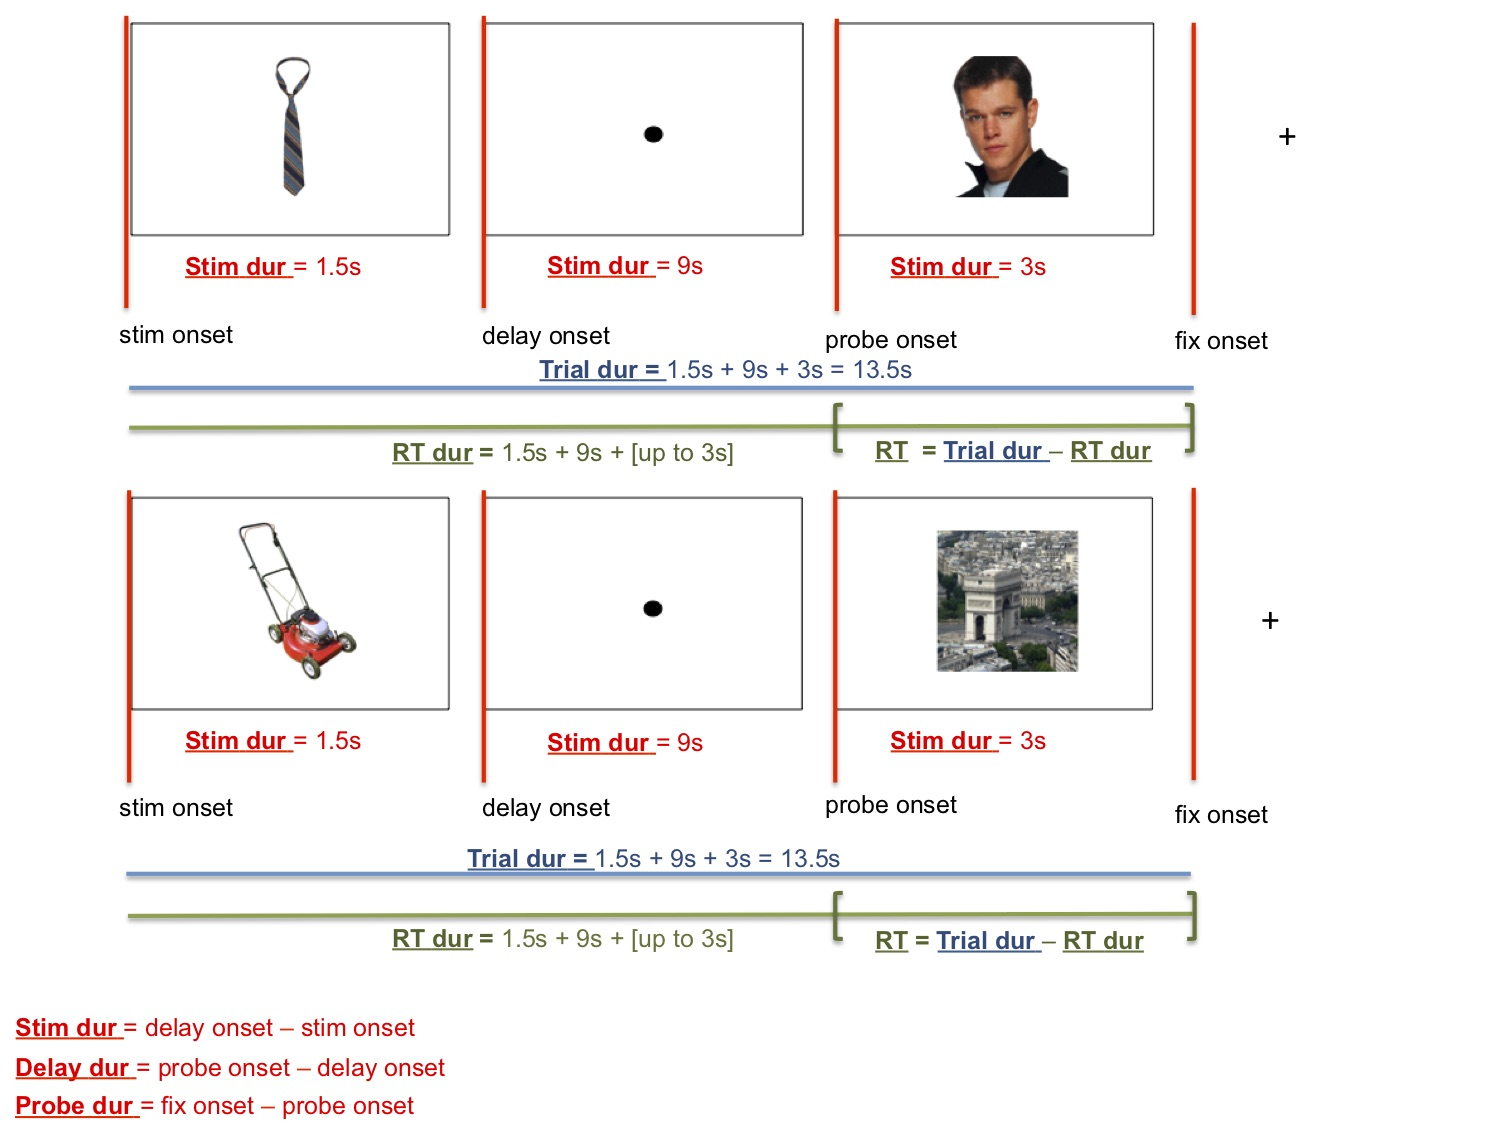

## Data Key

**Group** <br>
0 = Young Adults <br> 
1 = Older Adults

**Condition** <br>
1 = Face-Object Match <br>
2 = Face-Object Mismatch <br>
3 = Scene-Object Match <br>
4 = Scene-Object Mismatch 

**Face_Scene**
0 = Face
1 = Scene

## Aggregate data

In [6]:
df = pd.DataFrame()
for file in memmatch_files:
    
    partic = file.split('Behavioral/')[1]
    partic = int(partic[0:5])
    
    run = file.split('run')[1]
    run = run[:1]
    
    matfile = pd.read_csv(file, sep = '\t', na_values = ' NaN')
    matfile['record_id'] = partic
    matfile['run'] = run
    df = df.append(matfile)

df[' isCorrect'] = df[' isCorrect'].astype('float64')
df['RT_c'] = df[' RT'].where(df[' isCorrect'] == 1.0)
df['face_scene'] = np.where((df[' cond'] == 1) | (df[' cond'] == 2), 0, 1)
df['group'] = np.where(df['record_id'] < 40000, 0, 1)
df.columns = ['onset', 'pairType', 'fsStimID_probe', 'objStimID_cue', 'cond', 'duration', 'answer', 'resp', 'RT', 'isCorrect', 'record_id', 'run', 'RT_c', 'face_scene', 'group']

In [7]:
df[:5]

,onset,pairType,fsStimID_probe,objStimID_cue,cond,duration,answer,resp,RT,isCorrect,record_id,run,RT_c,face_scene,group
0,1.5,2,10,28,3,16.5,1,1.0,11611.0,1.0,30004,1,11611.0,1,0
1,21.0,2,4,36,4,16.5,0,2.0,11524.0,1.0,30004,1,11524.0,1,0
2,40.5,1,1,15,2,16.5,0,2.0,11341.0,1.0,30004,1,11341.0,0,0
3,61.5,2,17,34,3,16.5,1,1.0,11440.0,1.0,30004,1,11440.0,1,0
4,79.5,2,1,29,3,16.5,1,1.0,11442.0,1.0,30004,1,11442.0,1,0


In [8]:
df.to_csv('/Users/megmcmahon/Box/CogNeuroLab/Aging Decision Making R01/Data/memmatch_results.csv')

### Excluding participants with < 55% accuracy

In [9]:
datacheck = df.groupby(['record_id']).mean()
below_acc = datacheck[datacheck['isCorrect'] < 0.55]
exclude = below_acc.index
df_old = df
df = df_old[~df_old['record_id'].isin(exclude)]

In [10]:
print('**Total Participants Excluded**')
print('Excluded %d Young Adults' %(sum(exclude < 40000)))
print('Excluded %d Older Adults' %(sum(exclude >= 40000)))

**Total Participants Excluded**
Excluded 2 Young Adults
Excluded 10 Older Adults


## Accuracy

In [11]:
data = df.groupby(['record_id', 'cond']).mean()
data.reset_index(level=['cond'], inplace=True)

grouped_data= data.groupby(['cond', 'group'])
pd.DataFrame(grouped_data['isCorrect'].describe().unstack().transpose())

cond                 1          2          3          4
      group                                            
count 0      52.000000  52.000000  52.000000  52.000000
      1      52.000000  52.000000  52.000000  52.000000
mean  0       0.919231   0.881258   0.912393   0.880342
      1       0.855021   0.815171   0.856838   0.803846
std   0       0.107526   0.172009   0.115043   0.165897
      1       0.159801   0.192677   0.139745   0.174075
min   0       0.555556   0.222222   0.555556   0.333333
      1       0.222222   0.000000   0.555556   0.333333
25%   0       0.888889   0.777778   0.888889   0.861111
      1       0.777778   0.750000   0.777778   0.666667
50%   0       1.000000   1.000000   1.000000   1.000000
      1       0.888889   0.888889   0.888889   0.844444
75%   0       1.000000   1.000000   1.000000   1.000000
      1       1.000000   1.000000   1.000000   0.916667
max   0       1.000000   1.000000   1.000000   1.000000
      1       1.000000   1.000000   1.000000   1.000000

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Accuracy')

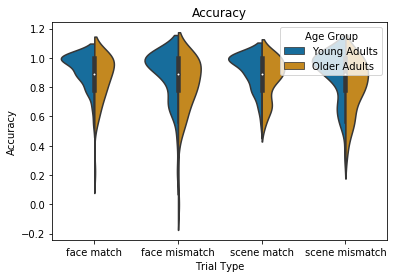

In [12]:
g = sns.violinplot(x='cond', y='isCorrect', hue='group', palette='colorblind', split=True, data=data)
g.set_xticklabels(['face match','face mismatch','scene match', 'scene mismatch'])
g.legend(title= 'Age Group',loc='upper right')
new_labels = ['Young Adults', 'Older Adults']
for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)
g.set(xlabel='Trial Type', ylabel='Accuracy')
g.set_title('Accuracy')

## Response Time

In [13]:
pd.DataFrame(grouped_data['RT_c'].describe().unstack().transpose())

cond                    1             2             3             4
      group                                                        
count 0         52.000000     52.000000     52.000000     52.000000
      1         52.000000     51.000000     52.000000     52.000000
mean  0      11435.413347  11441.036126  11485.154747  11522.565827
      1      11677.037286  11768.328719  11785.900702  11896.246535
std   0        228.135845    232.746992    242.592875    261.974768
      1        312.446675    239.487490    303.017414    282.469305
min   0      11009.500000  10979.888889  11059.250000  11020.666667
      1      11100.888889  11368.750000  11228.285714  11401.222222
25%   0      11267.166667  11257.166667  11319.527778  11366.510417
      1      11486.166667  11591.833333  11563.933333  11693.595238
50%   0      11417.125000  11413.166667  11469.604167  11459.000000
      1      11615.645833  11730.285714  11821.444444  11840.128571
75%   0      11565.419643  11547.805556  11597.714286  11634.125000
      1      11818.488095  11922.660714  12001.458333  12069.557143
max   0      11949.750000  12196.250000  12232.400000  12364.000000
      1      12693.200000  12419.600000  12446.000000  12543.000000

Text(0.5, 1.0, 'Response Time')

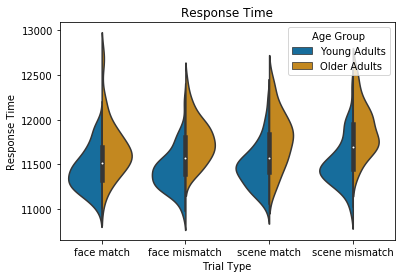

In [14]:
g = sns.violinplot(x='cond', y='RT_c', hue='group', palette='colorblind', split=True, data=data)
g.set_xticklabels(['face match','face mismatch','scene match', 'scene mismatch'])
g.legend(title= 'Age Group',loc='upper right')
new_labels = ['Young Adults', 'Older Adults']
for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)
g.set(xlabel='Trial Type', ylabel='Response Time')
g.set_title('Response Time')

For quick tips, see [Basic Stats in pandas Dataframes](https://medium.com/@kasiarachuta/basic-statistics-in-pandas-dataframe-594208074f85)

Two-way ANOVA code obtained from [Anova in Python](https://plot.ly/python/v3/anova/)

In [15]:
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'isCorrect ~ C(group) + C(cond) + C(group):C(cond)'
model = ols(formula, data).fit()
aov_table = statsmodels.stats.anova.anova_lm(model, typ=2)
print(aov_table)

                    sum_sq     df          F    PR(>F)
C(group)          0.447370    1.0  18.410560  0.000022
C(cond)           0.174691    3.0   2.396344  0.067713
C(group):C(cond)  0.005766    3.0   0.079099  0.971317
Residual          9.914252  408.0        NaN       NaN


## Performance over time

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Accuracy across Multiple Runs')

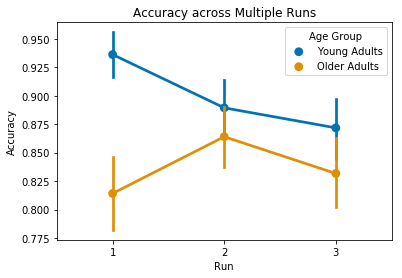

In [16]:
g = sns.pointplot(x='run', y='isCorrect', hue='group', palette='colorblind', data=df)
g.legend(title= 'Age Group',loc='upper right')
new_labels = ['Young Adults', 'Older Adults']
for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)
g.set(xlabel='Run', ylabel='Accuracy')
g.set_title('Accuracy across Multiple Runs')

Text(0.5, 1.0, 'Response Time across Multiple Runs')

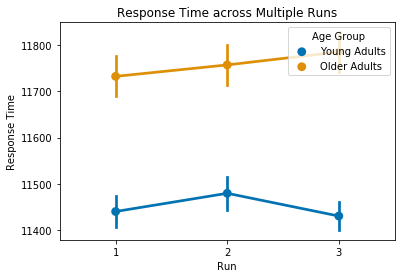

In [17]:
g = sns.pointplot(x='run', y='RT_c', hue='group', palette='colorblind', data=df)
g.legend(title= 'Age Group',loc='upper right')
new_labels = ['Young Adults', 'Older Adults']
for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)
g.set(xlabel='Run', ylabel='Response Time')
g.set_title('Response Time across Multiple Runs')

Text(0.5, 1.0, 'Young Adults \n Response Time across Multiple Runs')

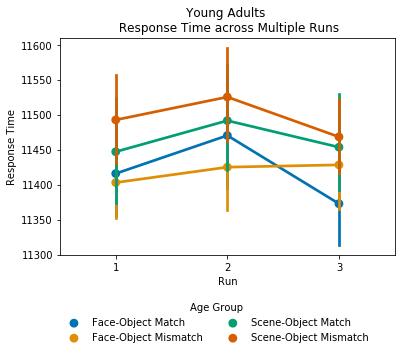

In [18]:
g = sns.pointplot(x='run', y='RT_c', hue='cond', palette='colorblind', data=df[df['group'] == 0])
g.legend(title= 'Age Group',loc='upper left', bbox_to_anchor= (0.0, -0.20), ncol=2, borderaxespad=0, frameon=False)
new_labels = ['Face-Object Match', 'Face-Object Mismatch', 'Scene-Object Match', 'Scene-Object Mismatch']
for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)
g.set(xlabel='Run', ylabel='Response Time')
g.set_title('Young Adults \n Response Time across Multiple Runs')

Text(0.5, 1.0, 'Older Adults \n Response Time across Multiple Runs')

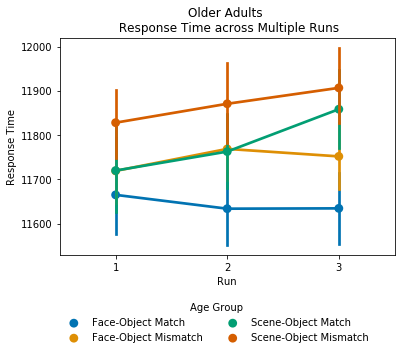

In [19]:
g = sns.pointplot(x='run', y='RT_c', hue='cond', palette='colorblind', data=df[df['group'] == 1])
g.legend(title= 'Age Group',loc='upper left', bbox_to_anchor= (0.0, -0.20), ncol=2, borderaxespad=0, frameon=False)
new_labels = ['Face-Object Match', 'Face-Object Mismatch', 'Scene-Object Match', 'Scene-Object Mismatch']
for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)
g.set(xlabel='Run', ylabel='Response Time')
g.set_title('Older Adults \n Response Time across Multiple Runs')